# APPENDIX C: Correlations

In [1]:
# TEST DELTA DEPENDENCIES WITHOUT MERGER CRITERION AND ONLY ABOVE 2 GYR

import os
import sys
import glob
from scipy import stats

import cuspcore_go
from cuspcore_aux import *
import pickle
import numpy
import scipy
from scipy.special import erf

Ttype='Tmulti'#'jeans-Mreal'
rmin_evolve=10**-1.75
rmax_evolve=1.
linear_slopes=False
t_min=3.
merger_thr=1.
logf_min=-3
logf_max=1

sims=[sim[52:60] for sim in glob.glob('/cs/sci/freundlich/CUSPCORE/ARTICLE/output_20190503_g[!s]*[!temp].pickle')]

t1_array_all=[]
t2_array_all=[]
Dsnapshot_all=[]
delta_all=[]
delta_i_all=[]
fmean_all=[]
fstd_all=[]
fmerger_all=[]
fprofile_all=[]
fprofile_simname=[]

for sim in sims:
    output_file_sim='/cs/sci/freundlich/CUSPCORE/ARTICLE/output_20190503_%s.pickle'%sim
    with open(output_file_sim) as f:
        output_sim = pickle.load(f)
    
    [percent_tot,t1_array,t2_array,Dsnapshot,delta,delta_i,fmean,fstd,fmerger,fprofile, fprofile_simname,criteria_threshold]=output_sim
    t1_array_all.append(t1_array[0])
    t2_array_all.append(t2_array[0])
    Dsnapshot_all.append(Dsnapshot[0])
    delta_all.append(delta[0])
    delta_i_all.append(delta_i[0])
    fmean_all.append(fmean[0])
    fstd_all.append(fstd[0])
    fmerger_all.append(fmerger[0])
    fprofile_all.append(fprofile)
    
output=[percent_tot,t1_array_all,t2_array_all,Dsnapshot_all,delta_all,delta_i_all,fmean_all,fstd_all,fmerger_all,fprofile_all, fprofile_simname,criteria_threshold]
count_output=count_successes_all(sims,output,merger_threshold=0.1,fit_threshold=0.05)

print 'Load: Done!'

########################################################

[percent_tot,t1_array_all,t2_array_all,Dsnapshot_all,delta_all,delta_i_all,fmean_all,fstd_all,fmerger_all,fprofile_all, fprofile_simname,criteria_threshold] =output
ngalaxies = shape(t1_array_all)[0]

########################################################

##### LOAD PROPERTY NAMES
catalog='/cs/sci/freundlich/CUSPCORE/catalogs/NIHAO_a%.4f.txt'%1.
colnames=genfromtxt(catalog,max_rows=1,dtype='S20')

##### LOAD TIMES
import pickle
directory='/cs/sci/freundlich/CUSPCORE/NIHAO_data/'
with open(directory+'NIHAO-%s.pickle'%sims[10][1:]) as f:
            gl = pickle.load(f)

a_array=[]
for (i,ss) in zip(range(size(gl)),gl):
            a_array.append(ss['a'])         
        
a_array=array(a_array)
z_array = 1./a_array - 1.
logz=log10(z_array)

time=array(t2_array_all).flatten().copy()

n_outputs=size(a_array)
sim_list=[]
i_array=[]
for i in range(size(sims)):
    sim_list=sim_list+[sims[i]]*n_outputs
    i_array=i_array+[i for i in range(n_outputs)]

sim_list=array(sim_list)
i_array=array(i_array)

#### GET DELTA AND SUCCESS 
delta=array(delta_all).flatten().copy()
delta_red=delta.copy()
delta_red[time<t_min]=nan*ones_like(delta_red[time<t_min])
dsim=abs(array(Dsnapshot_all).flatten().copy())
dsim_red=dsim.copy()

#### MASS RATIOS
frms=array(fmean_all).flatten().copy()
frms[frms==-inf]=nan
fmerger=abs(array(fmerger_all).flatten()).copy()
fmerger[fmerger==-inf]=nan
previous_fmerger=array([nan]+fmerger[:-1].tolist()).copy()

frms_red=frms.copy()
fmerger_red=fmerger.copy()
previous_fmerger_red=previous_fmerger.copy()

frms_red[log10(frms_red)==-inf]=nan
fmerger_red[log10(fmerger_red)==-inf]=nan

frms_red[log10(frms_red)<logf_min]=nan*ones_like(frms_red[log10(frms_red)<logf_min])
fmerger_red[log10(fmerger_red)<logf_min]=nan*ones_like(fmerger_red[log10(fmerger_red)<logf_min])
frms_red[log10(frms_red)>logf_max]=nan*ones_like(frms_red[log10(frms_red)>logf_max])
fmerger_red[log10(fmerger_red)>logf_max]=nan*ones_like(fmerger_red[log10(fmerger_red)>logf_max])

#### QUANTITIES FROM FANGZHOU JIANG'S CATALOG

mvir=[]
mstar=[]
mgas=[]
mcold=[]
SFR=[]
re_star=[]
n_sersic=[]
cnfw=[]
q=[]
p=[]

for ID in sims:
    for a in a_array:
        if a==a_array[0] or a ==a_array[1]:
            mvir.append(nan)
            mstar.append(nan)
            mgas.append(nan)
            mcold.append(nan)
            SFR.append(nan)
            re_star.append(nan)
            n_sersic.append(nan)
            cnfw.append(nan)
            p.append(nan)
            q.append(nan)
        else:
            catalog='/cs/sci/freundlich/CUSPCORE/catalogs/NIHAO_a%.4f.txt'%a
            data=genfromtxt(catalog,skip_header =1)
            try:
                ok_fangzhou,r12_fangzhou,rvir_fangzhou,mvir_fangzhou,mstar_fangzhou=get_fangzhou_radii(ID,[a],get_stars=True)
                i_ID=where(data[:,0]==float(ID[1:]))[0][0]
                mvir.append(mvir_fangzhou[0])
                mstar.append(data[i_ID,17])
                mgas.append(data[i_ID,18])
                mcold.append(data[i_ID,19])
                SFR.append(data[i_ID,20])
                re_star.append(data[i_ID,21])
                n_sersic.append(data[i_ID,32])
                cnfw.append(data[i_ID,12])
                q.append(data[i_ID,33])
                p.append(data[i_ID,34])    
            except:
                mvir.append(nan)
                mstar.append(nan)
                mgas.append(nan)
                mcold.append(nan)
                SFR.append(nan)
                re_star.append(nan)
                n_sersic.append(nan)
                cnfw.append(nan)
                q.append(nan)
                p.append(nan)

mvir=array(mvir)
mstar=array(mstar)
mgas=array(mgas)
mcold=array(mcold)
SFR=array(SFR)
re_star=array(re_star)
n_sersic=array(n_sersic)
cnfw=array(cnfw)
q=array(q)
p=array(p)


f=sqrt(1-p**2)
e=sqrt(1-q**2)
ef=e-f
epf=e+f

mugas=mgas/mstar
muhot=(mgas-mcold)/mstar
mucold=mcold/mstar

mugas_red=mugas.copy()
mugas_red[mugas_red>50]=nan*ones_like(mugas_red[mugas_red>50])
mucold_red=mucold.copy()
mucold_red[mucold_red>50]=nan*ones_like(mucold_red[mucold_red>50])

fgas=mgas/(mstar+mgas+mvir)
fcold=mcold/(mstar+mgas)
fhot=(mgas-mcold)/(mstar+mgas)
fb=(mgas+mstar)/(mgas+mstar+mvir)
fb_gas=mgas/(mgas+mstar+mvir)
fb_star=mstar/(mgas+mstar+mvir)

mugas_dm=mgas/mvir

#######################################################
# time as color
c=time.copy()
clabel=r'$t$ $\rm [Gyr]$'

print 'Done!'

/cs/sci/sharonl/miniconda/envs/iyt32/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


g1.57e11: 22/50 = 44 percent success
        : 15/30 = 50 percent success without mergers
        : 12/23 = 52 percent success when fmean > 0.06
        : 3/7 = 43 percent success when fmean < 0.06
g4.99e10: 27/50 = 54 percent success
        : 27/41 = 66 percent success without mergers
        : 12/23 = 52 percent success when fmean > 0.06
        : 15/18 = 83 percent success when fmean < 0.06
g3.21e11: 18/50 = 36 percent success
        : 16/33 = 48 percent success without mergers
        : 11/26 = 42 percent success when fmean > 0.06
        : 5/7 = 71 percent success when fmean < 0.06
g3.44e10: 18/50 = 36 percent success
        : 17/24 = 71 percent success without mergers
        : 13/16 = 81 percent success when fmean > 0.06
        : 4/8 = 50 percent success when fmean < 0.06
g3.59e11: 19/50 = 38 percent success
        : 17/25 = 68 percent success without mergers
        : 12/17 = 71 percent success when fmean > 0.06
        : 5/8 = 62 percent success when fmean < 0.06
g6.12e10

In [2]:
# GET THE PROFILE PARAMETERS

rmin_fit=0.01

import treal_functions
import general_functions
import slopes_functions
import prepare_functions
import fitting as fit
import cuspcore_aux
import cuspcore_plots
import evolving

reload(treal_functions)
reload(general_functions)
reload(slopes_functions)
reload(prepare_functions)
reload(fit)
reload(cuspcore_aux)
reload(cuspcore_plots)
reload(evolving)

from general_functions import *
from slopes_functions import *
from prepare_functions import *
from cuspcore_aux import *
from cuspcore_plots import *
from evolving import *


pi_all=[]
pf_all=[]
pmodel_all=[]

sin_i_all=[]
sin_f_all=[]
sin_model_all=[]

cmax_i_all=[]
cmax_f_all=[]
cmax_model_all=[]

Dsin_if_all=[]
Dsin_model_all=[]
Rsin_if_all=[]
Rsin_model_all=[]
Ds_all=[]

Dcmax_if_all=[]
Dcmax_model_all=[]
Rcmax_if_all=[]
Rcmax_model_all=[]
Dc_all=[]

for sim in sims:
    try:
        output_file_sim='/cs/sci/freundlich/CUSPCORE/ARTICLE/poutput_20190503_%s.pickle'%sim
        with open(output_file_sim) as f:
            output_sim = pickle.load(f)

        [_, _, _, _, _, _, _, p_i, p_f, p_model]=output_sim
        pi_all.append(p_i[0])
        pf_all.append(p_f[0])
        pmodel_all.append(p_model[0])
        
        sin_i=[]
        sin_f=[]
        sin_model=[]
        for ioutput in range(shape(p_i[0])[0]):
            try:    sin_i.append(prf.s(rmin_fit*p_i[0][ioutput][4],p_i[0][ioutput]))
            except: sin_i.append(nan)
            try:    sin_f.append(prf.s(rmin_fit*p_f[0][ioutput][4],p_f[0][ioutput]))
            except: sin_f.append(nan)
            try:    sin_model.append(prf.s(rmin_fit*p_model[0][ioutput][4],p_model[0][ioutput]))
            except: sin_model.append(nan) 

        sin_i=array(sin_i)
        sin_f=array(sin_f)
        sin_model=array(sin_model)
        Dsin_if=sin_f-sin_i
        Dsin_model=sin_model-sin_i
        Rsin_if=sin_f/sin_i
        Rsin_model=sin_model/sin_i
        
        sin_i_all.append(sin_i)
        sin_f_all.append(sin_f)
        sin_model_all.append(sin_model)
        Dsin_if_all.append(Dsin_if)
        Dsin_model_all.append(Dsin_model)
        Rsin_if_all.append(Rsin_if)
        Rsin_model_all.append(Rsin_model)
        
        cmax_i=[]
        cmax_f=[]
        cmax_model=[]
        for ioutput in range(shape(p_i[0])[0]):
            try:    cmax_i.append(prf.cmax(p_i[0][ioutput]))
            except: cmax_i.append(nan)
            try:    cmax_f.append(prf.cmax(p_f[0][ioutput]))
            except: cmax_f.append(nan)
            try:    cmax_model.append(prf.cmax(p_model[0][ioutput]))
            except: cmax_model.append(nan) 

        cmax_i=array(cmax_i)
        cmax_f=array(cmax_f)
        cmax_model=array(cmax_model)
        Dcmax_if=cmax_f-cmax_i
        Dcmax_model=cmax_model-cmax_i
        Rcmax_if=cmax_f/cmax_i
        Rcmax_model=cmax_model/cmax_i
        
        cmax_i_all.append(cmax_i)
        cmax_f_all.append(cmax_f)
        cmax_model_all.append(cmax_model)
        Dcmax_if_all.append(Dcmax_if)
        Dcmax_model_all.append(Dcmax_model)
        Rcmax_if_all.append(Rcmax_if)
        Rcmax_model_all.append(Rcmax_model)

    except:
        print 'No poutput for %s'%sim

Dsin_if=array(Dsin_if_all).copy().flatten()
Dsin_model=array(Dsin_model_all).copy().flatten()
Rsin_if=array(Rsin_if_all).copy().flatten()
Rsin_model=array(Rsin_model_all).copy().flatten()

Dcmax_if=array(Dcmax_if_all).copy().flatten()
Dcmax_model=array(Dcmax_model_all).copy().flatten()
Rcmax_if=array(Rcmax_if_all).copy().flatten()
Rcmax_model=array(Rcmax_model_all).copy().flatten()

Dsnapshot_threshold=0.1
deltai=abs(array(delta_i_all).flatten().copy())

# DEFINE IS_SUCCESS_ALL AND IS_MERGER_ALL
is_merger_all=[]
is_success_all=[]
for i in range(size(sims)):
    for ioutput in range(n_outputs):
        if ioutput==0:
            is_merger_all.append(False)
            is_success_all.append(False)
        else:
            is_merger=(fmerger[i*n_outputs:(i+1)*n_outputs][ioutput]>0.1)
            is_success=((delta[i*n_outputs:(i+1)*n_outputs][ioutput]<=Dsnapshot_threshold) and ((delta[i*n_outputs:(i+1)*n_outputs][ioutput]<=deltai[i*n_outputs:(i+1)*n_outputs][ioutput]) or (dsim[i*n_outputs:(i+1)*n_outputs][ioutput]<=0.03)))
            is_merger_all.append(is_merger)
            is_success_all.append(is_success)

is_merger_all=array(is_merger_all)
is_success_all=array(is_success_all)
print 'Done!'

Done!


t-delta : y = -1.07 + -0.0518 x 
t-fmerger : y = -1.02 + -0.0679 x 
t-re : y = 0.17 + 0.0328 x 
t-fgas : y = -1.16 + -0.0405 x 
t-mgas : y = 9.37 + 0.0105 x 
t-mstar : y = 7.77 + 0.0792 x 
t-mvir : y = 10.59 + 0.0478 x 
mvir-delta : y = -0.87 + -0.0597 x 
mvir-fmerger : y = -0.25 + -0.1226 x 
mvir-re : y = -3.98 + 0.4036 x 
mvir-fgas : y = -3.26 + 0.1590 x 
mvir-mgas : y = -3.26 + 1.1590 x 
mvir-mstar : y = -10.21 + 1.6996 x 
mstar-delta : y = -0.32 + -0.1413 x 
mstar-fmerger : y = -0.08 + -0.1786 x 
mstar-re : y = -1.23 + 0.1996 x 
mstar-fgas : y = -2.26 + 0.0885 x 
mstar-mgas : y = 4.34 + 0.6073 x 
mgas-delta : y = -2.80 + 0.1340 x 
mgas-fmerger : y = -2.84 + 0.1294 x 
mgas-re : y = -1.95 + 0.2535 x 
mgas-fgas : y = -4.98 + 0.3658 x 
fgas-delta : y = -0.60 + 0.6166 x 
fgas-fmerger : y = -0.51 + 0.7301 x 
fgas-re : y = 0.64 + 0.1163 x 
re-delta : y = -1.47 + -0.1079 x 
re-fmerger : y = -1.45 + -0.3213 x 
frms-delta : y = -0.57 + 0.5765 x 


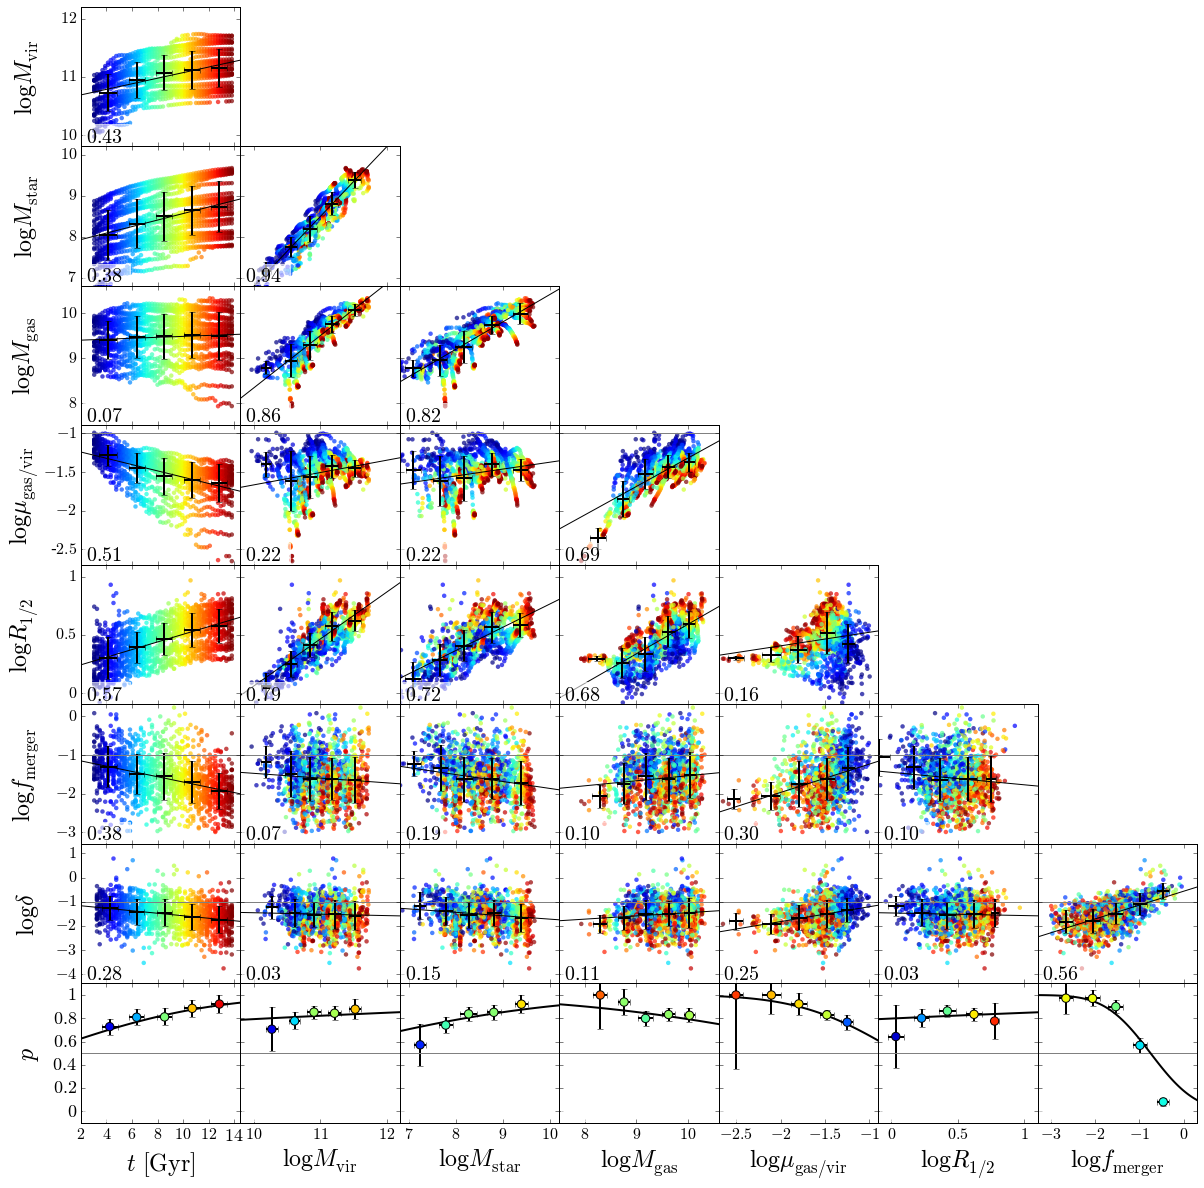

In [4]:
Dfit_threshold=0.1
ncols=7
nrows=8
fontsize=24

# CORRELATION ARRAY

import correlations
from correlations import *

# logz as color
c=time[time>t_min]
clabel=r'$t$ $\rm [Gyr]$'
c_string='d_t_'

x_quantities=[time[time>t_min],log10(mvir)[time>t_min],log10(mstar)[time>t_min],log10(mgas)[time>t_min],log10(mugas_dm[time>t_min]),log10(re_star)[time>t_min],log10(fmerger_red)[time>t_min]] #log10(abs(frms_red))[time>t_min],
x_names=[r'$t$ $\rm [Gyr]$',r'$\log M_{\rm vir}$',r'$\log M_{\rm star}$',r'$\log M_{\rm gas}$',r'$\log\mu_{\rm gas/vir}$',r'$\log R_{\rm 1/2}$',r'$\log f_{\rm merger}$'] #r'$\log |f|_{\rm RMS}$',
x_snames=['t','mvir','mstar','mgas','fgas','re','frms','fmerger']
x_lims=[[2.,14.5],[9.8,12.2],[6.8,10.2],[7.5,10.6],[-2.7,-0.9],[-0.1,1.1],[-3.3,0.3]] #,[-3.3,1.3]
x_ticks=[[2,4,6,8,10,12,14],[10,11,12],[7,8,9,10],[8,9,10],[-2.5,-2,-1.5,-1],[0,0.5,1],[-3,-2,-1,0]] #,[-3,-2,-1,0,1]
x_labels=[[r'$2$',r'$4$',r'$6$',r'$8$',r'$10$',r'$12$',r'$14$'],[r'$10$',r'$11$',r'$12$'],[r'$7$',r'$8$',r'$9$',r'$10$'],[r'$8$',r'$9$',r'$10$'],[r'$-2.5$',r'$-2$',r'$-1.5$',r'$-1$'],[r'$0$',r'$0.5$',r'$1$'],[r'$-3$',r'$-2$',r'$-1$',r'$0$']] #,[r'$-3$',r'$-2$',r'$-1$',r'$0$',r'$1$']

y_quantities=[log10(abs(delta_red))[time>t_min],log10(delta_red)[time>t_min],log10(fmerger_red)[time>t_min],log10(re_star)[time>t_min],log10(mugas_dm)[time>t_min],log10(mgas)[time>t_min],log10(mstar)[time>t_min],log10(mvir)[time>t_min]]
y_names=[r'$p$',r'$\log\delta$',r'$\log f_{\rm merger}$',r'$\log R_{\rm 1/2}$',r'$\log\mu_{\rm gas/vir}$',r'$\log M_{\rm gas}$',r'$\log M_{\rm star}$',r'$\log M_{\rm vir}$']
y_snames=['p','delta','fmerger','re','fgas','mgas','mstar','mvir']
y_lims=[[-0.1,1.1],[-4.4,1.4],[-3.3,0.3],[-0.1,1.1],[-2.7,-0.9],[7.5,10.6],[6.8,10.2],[9.8,12.2]]
y_ticks=[[0,0.2,0.4,0.6,0.8,1],[-4,-3,-2,-1,0,1],[-3,-2,-1,0],[0,0.5,1],[-2.5,-2,-1.5,-1],[8,9,10],[7,8,9,10],[10,11,12]]
y_labels=[[r'$0$',r'$0.2$',r'$0.4$',r'$0.6$',r'$0.8$',r'$1$'],[r'$-4$',r'$-3$',r'$-2$',r'$-1$',r'$0$',r'$1$'],[r'$-3$',r'$-2$',r'$-1$',r'$0$'],[r'$0$',r'$0.5$',r'$1$'],[r'-$2.5$',r'$-2$',r'$-1.5$',r'$-1$'],[r'$8$',r'$9$',r'$10$'],[r'$7$',r'$8$',r'$9$',r'$10$'],[r'$10$',r'$11$',r'$12$']]

fig,axes=subplots(nrows,ncols,figsize=(20,20))
for icol in range(ncols):
    for irow in range(nrows):
        if irow==0:
            ax=plot_success(x_quantities[icol],log10(delta_red)[time>t_min],qname=x_snames[icol]+'-'+y_snames[irow],c=c,xname=x_names[icol],yname=y_names[irow],ylim=y_lims[irow],xlim=x_lims[icol],x_ticks=x_ticks[icol],y_ticks=y_ticks[irow],y_labels=y_labels[irow],clabel=clabel,Dfit_threshold=log10(Dfit_threshold),standalone=False,ax=axes[nrows-1-irow,icol],rasterized= True)
        else:
            if icol<ncols-irow+1:
                ax=plot_correlation(x_quantities[icol],y_quantities[irow],qname=x_snames[icol]+'-'+y_snames[irow],c=c,xname=x_names[icol],yname=y_names[irow],fontsize=fontsize,ylim=y_lims[irow],clabel=clabel,Dfit_threshold=log10(Dfit_threshold),xlim=x_lims[icol],x_ticks=x_ticks[icol],x_labels=x_labels[icol],y_ticks=y_ticks[irow],y_labels=y_labels[irow],standalone=False,ax=axes[nrows-1-irow,icol],rasterized= True)
                axes[nrows-1-irow,icol].get_shared_x_axes().join(axes[nrows-1-irow,icol], axes[0,icol])
                if icol<>0:
                    axes[nrows-1-irow,icol].get_shared_y_axes().join(axes[nrows-1-irow,icol], axes[nrows-1-irow,0])
            else:
                axes[nrows-1-irow,icol].axis('off')
        
        if icol==0:
            axes[nrows-1-irow,icol].set_xlabel(' ')
            axes[nrows-1-irow,icol].tick_params(axis='x',labelbottom='off')
            axes[nrows-1-irow,icol].set_yticks(y_ticks[irow])
            axes[nrows-1-irow,icol].set_yticklabels(y_labels[irow])
            axes[nrows-1-irow,icol].yaxis.set_label_coords(-0.25,0.5)
        else:
            axes[nrows-1-irow,icol].set_xlabel(' ')
            axes[nrows-1-irow,icol].set_ylabel(' ')
            axes[nrows-1-irow,icol].tick_params(axis='x',labelbottom='off')
            axes[nrows-1-irow,icol].tick_params(axis='y',labelleft='off')
        
        if irow==0:
            axes[nrows-1-irow,icol].tick_params(axis='x',labelbottom='on')
            axes[nrows-1-irow,icol].set_xlabel(x_names[icol])
            axes[nrows-1-irow,icol].set_xticks(x_ticks[icol])
            axes[nrows-1-irow,icol].set_xticklabels(x_labels[icol])
            
fig.subplots_adjust(wspace=0,hspace=0)

In [5]:
Dsin=log10(abs(array(sin_model_all).copy().flatten()-array(sin_f_all).copy().flatten()))
Dcmax=log10(abs(log10(array(cmax_model_all).copy().flatten())-log10(array(cmax_f_all).copy().flatten())))


In [37]:
Dsmax=0.05
print 'Percent with Ds<%.2f             : %.2f'%(Dsmax,size(where(array_nonan(Dsin)<log10(Dsmax)))/float(size(array_nonan(Dsin))))
print 'Percent with Ds<%.2f (no mergers): %.2f'%(Dsmax,size(where(array_nonan(Dsin[fmerger<=0.1])<log10(Dsmax)))/float(size(array_nonan(Dsin[fmerger<=0.1]))))
print 'Percent with Ds<%.2f (mergers)   : %.2f'%(Dsmax,size(where(array_nonan(Dsin[fmerger>0.1])<log10(Dsmax)))/float(size(array_nonan(Dsin[fmerger>0.1]))))

print ''
Dsmax=0.1
print 'Percent with Ds<%.2f             : %.2f'%(Dsmax,size(where(array_nonan(Dsin)<log10(Dsmax)))/float(size(array_nonan(Dsin))))
print 'Percent with Ds<%.2f (no mergers): %.2f'%(Dsmax,size(where(array_nonan(Dsin[fmerger<=0.1])<log10(Dsmax)))/float(size(array_nonan(Dsin[fmerger<=0.1]))))
print 'Percent with Ds<%.2f (mergers)   : %.2f'%(Dsmax,size(where(array_nonan(Dsin[fmerger>0.1])<log10(Dsmax)))/float(size(array_nonan(Dsin[fmerger>0.1]))))


Percent with Ds<0.05             : 0.43
Percent with Ds<0.05 (no mergers): 0.47
Percent with Ds<0.05 (mergers)   : 0.13

Percent with Ds<0.10             : 0.68
Percent with Ds<0.10 (no mergers): 0.73
Percent with Ds<0.10 (mergers)   : 0.31


q : y = -0.18 + 0.7217 x 


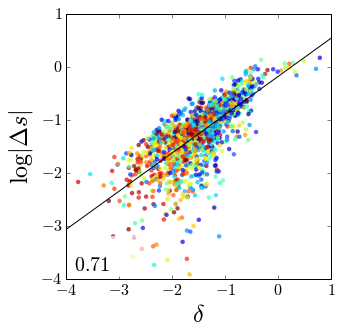

In [7]:
space_down=0.18
space_left=0.07
width=0.21
height=width*18./6.*3.5/3.
figsize=(7,5)
    
fig, ax = subplots(nrows=1, ncols=1,figsize=figsize)
plot_correlation(log10(delta_red)[time>t_min],Dsin[time>t_min],c=time[time>t_min],plot_errorbar=False,xname=r'$\delta$',yname=r'$\log|\Delta s|$',xlim=[-4,1],ylim=[-4,1],x_ticks=[-4,-3,-2,-1,0,1],x_labels=[r'$-4$',r'$-3$',r'$-2$',r'$-1$',r'$0$',r'$1$'],y_ticks=[-4,-3,-2,-1,0,1,2],y_labels=[r'$-4$',r'$-3$',r'$-2$',r'$-1$',r'$0$',r'$1$',r'$2$'],Dfit_threshold=10,standalone=False,ax=ax,rasterized= True)
ax.set_position([space_left+0.13,space_down, height*5./7., height])

q : y = -0.74 + 0.4217 x 


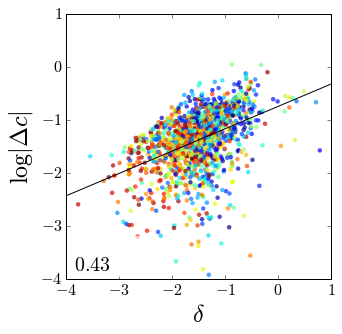

In [8]:
fig, ax = subplots(nrows=1, ncols=1,figsize=figsize)
plot_correlation(log10(delta_red)[time>t_min],Dcmax[time>t_min],c=time[time>t_min],plot_errorbar=False,xname=r'$\delta$',yname=r'$\log|\Delta c|$',xlim=[-4,1],ylim=[-4,1],x_ticks=[-4,-3,-2,-1,0,1],x_labels=[r'$-4$',r'$-3$',r'$-2$',r'$-1$',r'$0$',r'$1$'],y_ticks=[-4,-3,-2,-1,0,1,2],y_labels=[r'$-4$',r'$-3$',r'$-2$',r'$-1$',r'$0$',r'$1$',r'$2$'],Dfit_threshold=10,standalone=False,ax=ax,rasterized= True)
ax.set_position([space_left+0.13,space_down, height*5./7., height])

q : y = -0.74 + 0.5064 x 


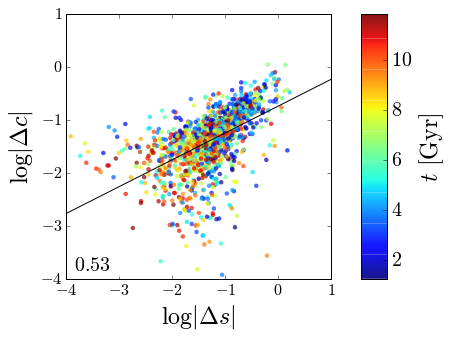

In [9]:
fig, ax = subplots(nrows=1, ncols=1,figsize=figsize)
plot_correlation(Dsin[time>t_min],Dcmax[time>t_min],c=time[time>t_min],plot_errorbar=False,plot_colorbar=True,xname=r'$\log|\Delta s|$',yname=r'$\log|\Delta c|$',xlim=[-4,1],ylim=[-4,1],x_ticks=[-4,-3,-2,-1,0,1],x_labels=[r'$-4$',r'$-3$',r'$-2$',r'$-1$',r'$0$',r'$1$'],y_ticks=[-4,-3,-2,-1,0,1,2],y_labels=[r'$-4$',r'$-3$',r'$-2$',r'$-1$',r'$0$',r'$1$',r'$2$'],cname=r'$t$ $\rm [Gyr]$',c_ticks=[2,4,6,8,10,12,14],c_labels=[r'$2$',r'$4$',r'$6$',r'$8$',r'$10$',r'$12$',r'$14$'],Dfit_threshold=10,standalone=False,ax=ax,rasterized= True)
ax.set_position([space_left+0.13,space_down, height*5./7., height])